In [1]:
library(tidyverse)
library(caret)
library(randomForest)
library(e1071)
library(doParallel)

options(digits=5)
options(warn=-1)
options(width=100)

R.Version()$version.string
print(map_chr(c('tidyverse','caret','randomForest','e1071'),
              function(x){paste(x,': ',packageVersion(x),', ',sep='')}), quote=F)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.1.1     √ purrr   0.3.2
√ tibble  2.1.1     √ dplyr   0.8.1
√ tidyr   0.8.3     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'pa

[1] "R version 3.6.0 Patched (2019-04-28 r76433)"

[1] tidyverse: 1.2.1,      caret: 6.0.84,         randomForest: 4.6.14,  e1071: 1.7.1,         


In [2]:
#============================
# Read Data

train <- read_csv('pml-training.csv')
test  <- read_csv('pml-testing.csv' )

Parsed with column specification:
cols(
  .default = col_double(),
  user_name = col_character(),
  cvtd_timestamp = col_character(),
  new_window = col_character(),
  kurtosis_roll_belt = col_character(),
  kurtosis_picth_belt = col_character(),
  kurtosis_yaw_belt = col_character(),
  skewness_roll_belt = col_character(),
  skewness_roll_belt.1 = col_character(),
  skewness_yaw_belt = col_character(),
  max_yaw_belt = col_character(),
  min_yaw_belt = col_character(),
  amplitude_yaw_belt = col_character(),
  kurtosis_picth_arm = col_character(),
  kurtosis_yaw_arm = col_character(),
  skewness_pitch_arm = col_character(),
  skewness_yaw_arm = col_character(),
  kurtosis_yaw_dumbbell = col_character(),
  skewness_yaw_dumbbell = col_character(),
  kurtosis_roll_forearm = col_character(),
  kurtosis_picth_forearm = col_character()
  # ... with 8 more columns
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_logical(),
  X1 = col_do

In [3]:
#============================
# Pre Process Sample Date

train <- train %>% mutate(flag='train')
test  <- test  %>% mutate(flag='test' ) %>% 
          mutate(problem_id=as.character(problem_id)) %>% rename(classe=problem_id)

all  <- bind_rows(train,test) %>% select(names(train)[-c(1,3:7)])
drop <- map_lgl(all[,2:153], function(c){ any(is.na(c))} )      # Drop columns contain NA
all <- all[, c(T,!drop,T,T)]
print(ncol(all))

train <- all %>% filter(flag=='train') %>% select(-flag) %>% mutate(classe=factor(classe))
test  <- all %>% filter(flag=='test')  %>% select(-flag)

[1] 55


In [4]:
#============================
# Split Training Data to train, valid

index <- createDataPartition(train$classe, p=0.8, list=F, times=1)
train.t <- train[ index,]
train.v <- train[-index,]

In [5]:
#============================
# Fit randomForest
# Change the number of samples and observe the errors that in and out of sample

accu <- data.frame()
for(i in c(5,10,15,20,30,50,100)){ # Percent of Test set
    set.seed(0)
    index <- createDataPartition(train.t$classe, p=i/100, list=F, times=1)
    train.x <- train.t[ index,]

        cl <- makeCluster(detectCores()) # for Parallel processing
        registerDoParallel(cl)           #
    #-- Fit ----
    modFit <- train(classe~., method='rf', data=train.x,
                    trControl=trainControl(method = 'cv', number=10))
    #-----------
        stopCluster(cl)                 #

    # Accuracy fitted in sample
    x <- confusionMatrix(predict(modFit,newdata=train.x), train.x$classe)
    # Accuracy out of sample
    v <- confusionMatrix(predict(modFit,newdata=train.v), train.v$classe)

    accu <- bind_rows(accu, 
                      data.frame(n_samples =nrow(train.x),
                                 x_accu=x$overall['Accuracy'], 
                                 v_accu=v$overall['Accuracy']))
}

In [6]:
#============================
# Validate Model

print(accu)
cat('\n== In Sample ======== Accuracy and ConfusionMatrix\n')
print(x$overall['Accuracy'])
print(x$table)
cat('\n== Out of Sample ==== Accuracy and ConfusionMatrix\n')
print(v$overall['Accuracy'])
print(v$table)

  n_samples x_accu  v_accu
1       787      1 0.89396
2      1572      1 0.93500
3      2356      1 0.95463
4      3142      1 0.96992
5      4712      1 0.97476
6      7850      1 0.98700
7     15699      1 0.99541

== In Sample ======== Accuracy and ConfusionMatrix
Accuracy 
       1 
          Reference
Prediction    A    B    C    D    E
         A 4464    0    0    0    0
         B    0 3038    0    0    0
         C    0    0 2738    0    0
         D    0    0    0 2573    0
         E    0    0    0    0 2886

== Out of Sample ==== Accuracy and ConfusionMatrix
Accuracy 
 0.99541 
          Reference
Prediction    A    B    C    D    E
         A 1115    4    0    0    0
         B    1  754    2    0    0
         C    0    1  679    3    2
         D    0    0    3  639    1
         E    0    0    0    1  718


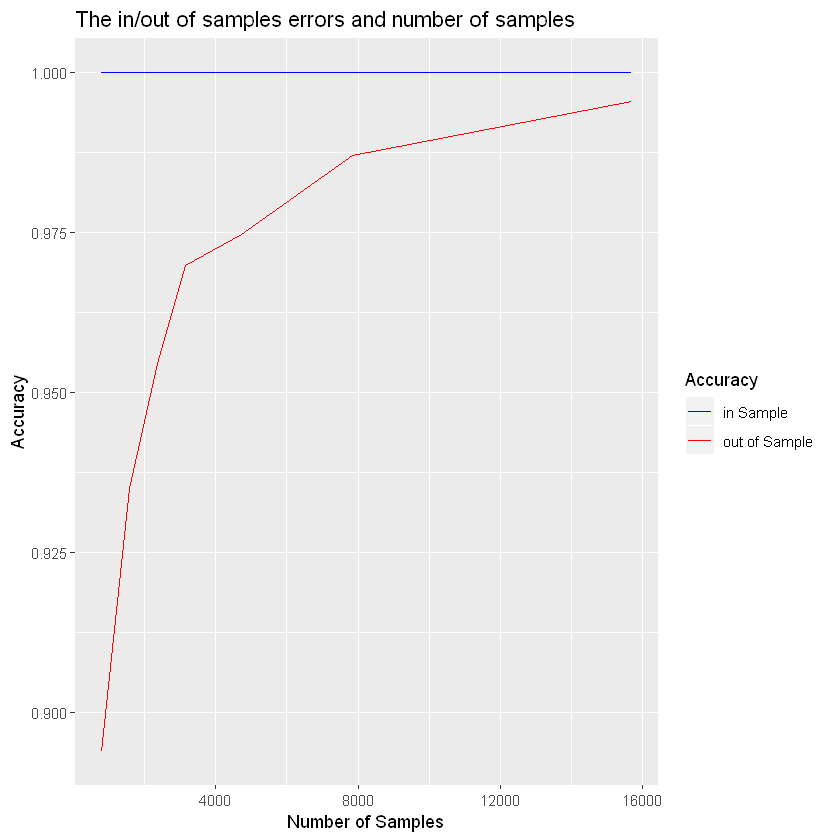

In [7]:
#============================
# Visualize

p <- ggplot(accu, aes(x=n_samples)) +
     geom_line(aes(y=x_accu, colour='in Sample' ) ) +
     geom_line(aes(y=v_accu, colour='out of Sample') ) +
     scale_colour_manual('Accuracy', values=c('in Sample'='blue', 'out of Sample'='red')) +
     labs(title='The in/out of samples errors and number of samples',
          x='Number of Samples', y='Accuracy')
plot(p)

In [8]:
#============================
# Predict from Test set

pred <- predict(modFit, newdata=test)
print(pred)

 [1] B A B A A E D B A A B C B A E E A B B B
Levels: A B C D E
